# Step 1: Camera Calibration

In [1]:
from calibrate import calibrate_camera

calibrate_camera(save_file=True)

Save result to ./presets/calibrate.p


(array([[1.15396100e+03, 0.00000000e+00, 6.69706490e+02],
        [0.00000000e+00, 1.14802504e+03, 3.85655584e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-2.41018756e-01, -5.30666106e-02, -1.15811356e-03,
         -1.28285248e-04,  2.67027151e-02]]))

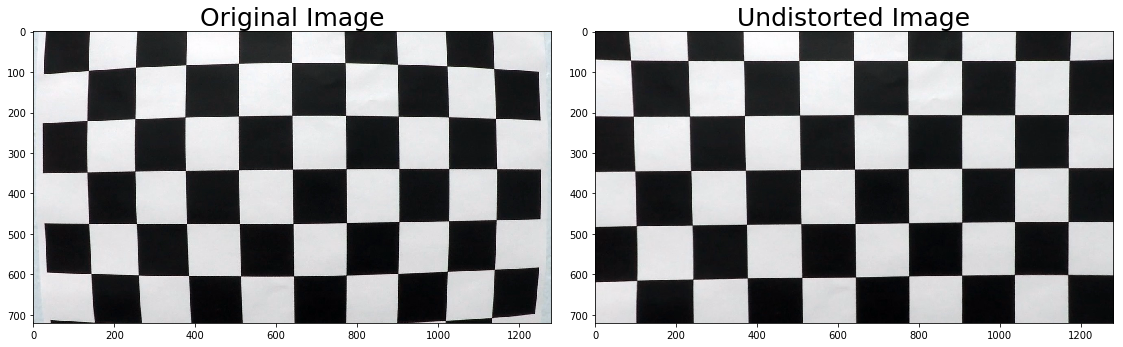

In [1]:
# Load presets and undistort image
import pickle
import cv2
import matplotlib.pyplot as plt
from calibrate import undistort

%matplotlib inline

def compare_img(orig, new, orig_title, new_title, orig_gray=False, new_gray=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    f.tight_layout()
    if orig_gray:
        ax1.imshow(orig, cmap='gray')
    else:
        ax1.imshow(orig)
    ax1.set_title(orig_title, fontsize=25)
    if new_gray:
        ax2.imshow(new, cmap='gray')
    else:
        ax2.imshow(new)
    ax2.set_title(new_title, fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

TEST_IMG_PATH = "./camera_cal/calibration1.jpg" 

dist_pickle = pickle.load(open("./presets/calibrate.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

orig_img = cv2.imread(TEST_IMG_PATH)
undist_img = undistort(orig_img, mtx, dist)
    
compare_img(orig_img, undist_img, 'Original Image', 'Undistorted Image')

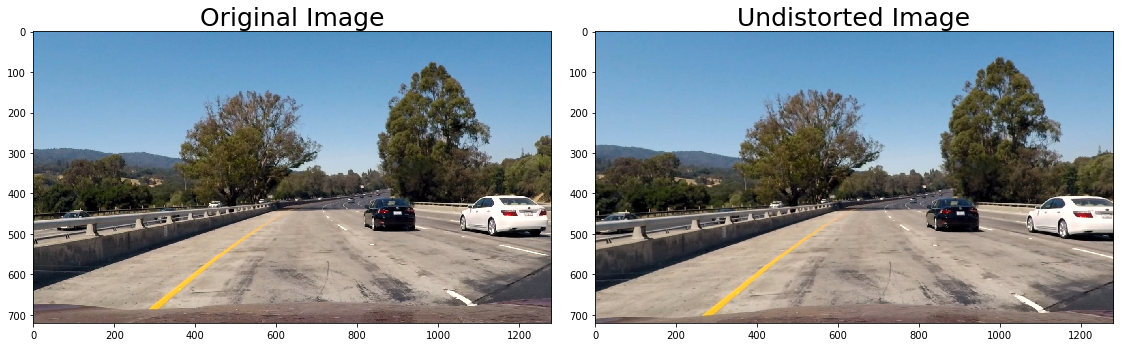

In [2]:
# Undistort road image
TEST_IMG_PATH = "./test_images/test1.jpg"

orig_img = cv2.imread(TEST_IMG_PATH)
# Convert to RGB space
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
undist_img = undistort(orig_img, mtx, dist)

compare_img(orig_img, undist_img, 'Original Image', 'Undistorted Image')

# Step 2: Apply Gradient and Color Threshold to Isolate Lane Marks

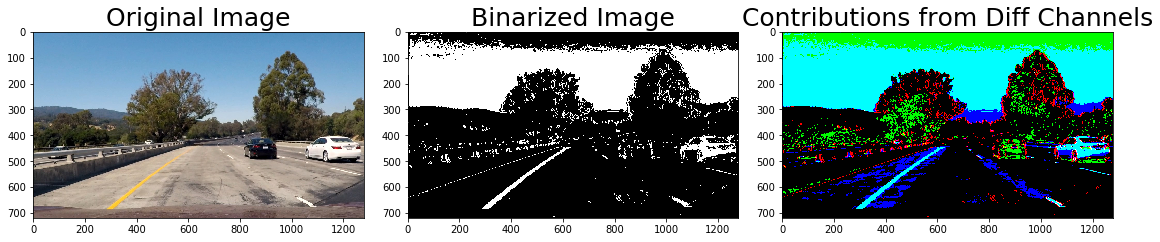

In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import imgfilter
import numpy as np

TEST_IMG_PATH = "./test_images/test1.jpg"
orig_img = mpimg.imread(TEST_IMG_PATH)

binarized, channels = imgfilter.binarize(orig_img,
                                  kernel=17,
                                  x_thresh=(30, 255), y_thresh=(30, 255), 
                                  magni_thresh=(50, 150), dir_thresh=(0, np.pi/3),
                                  sat_thresh=(100, 255), val_thresh=(200, 255))

# compare_img(binarized, channels, 'Binarized Image', 'Contributions from Every Channel', orig_gray=True)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
f.tight_layout()
ax1.imshow(orig_img)
ax1.set_title("Original Image", fontsize=25)
ax2.imshow(binarized, cmap='gray')
ax2.set_title("Binarized Image", fontsize=25)
ax3.imshow(channels)
ax3.set_title("Contributions from Diff Channels", fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Step 3:  Apply Perspective Transform

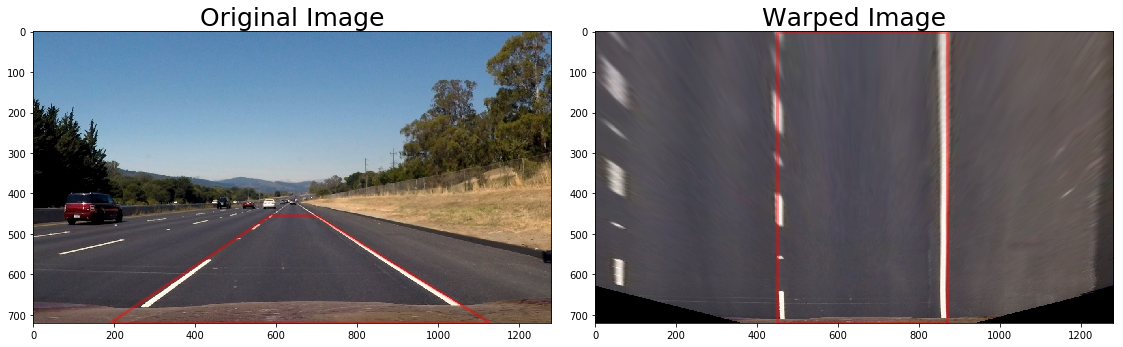

In [4]:
from calibrate import bird_eye_view

TEST_IMG_PATH = "./test_images/straight_lines2.jpg"
orig_img = mpimg.imread(TEST_IMG_PATH)

offset = 260
corners = np.float32([[190,720],[585,455],[700,455],[1130,720]])
dst = np.float32([[corners[0][0] + offset, corners[0][1]],
                      [corners[0][0] + offset, 0],
                      [corners[3][0] - offset, 0],
                      [corners[3][0] - offset, corners[3][1]]])   

warped_img, _, _ = bird_eye_view(orig_img)
#                               , offset, corners)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout()
x = [corners[0][0],corners[1][0],corners[2][0],corners[3][0],corners[0][0]]
y = [corners[0][1],corners[1][1],corners[2][1],corners[3][1],corners[0][1]]
ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.imshow(orig_img)
ax1.set_title('Original Image', fontsize=25)
x = [dst[0][0],dst[1][0],dst[2][0],dst[3][0],dst[0][0]]
y = [dst[0][1],dst[1][1],dst[2][1],dst[3][1],dst[0][1]]
ax2.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax2.imshow(warped_img)
ax2.set_title('Warped Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

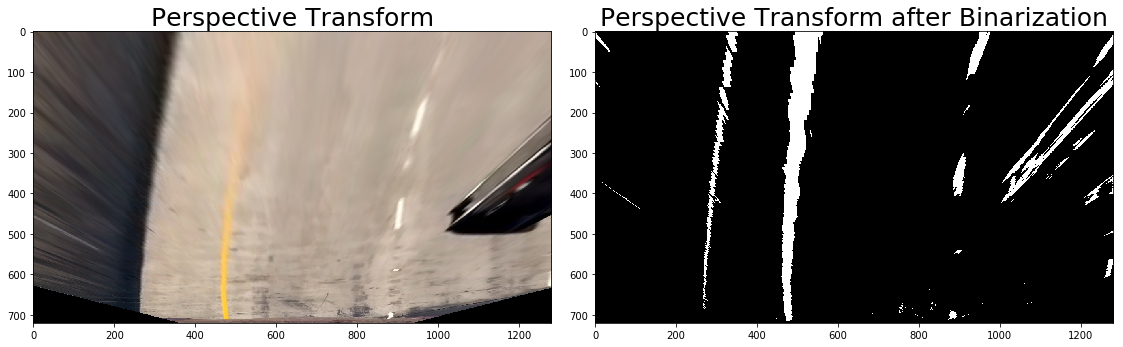

In [5]:
# Complete pipeline
import numpy as np
# import cv2
import pickle
import calibrate 
import imgfilter
# import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def pipeline(img_path, coef_path="./presets/calibrate.p"):
    dist_pickle = pickle.load(open(coef_path, "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    img = mpimg.imread(img_path)
    img = calibrate.undistort(img, mtx, dist)
    binary, _ = imgfilter.binarize(img)
    bird_eye, _, Minv = calibrate.bird_eye_view(binary, offset, corners)
    return bird_eye, Minv

TEST_IMG_PATH = "./test_images/test1.jpg"
orig_img = mpimg.imread(TEST_IMG_PATH)
bird_eye, _, _ = calibrate.bird_eye_view(orig_img)
filtered_bird_eye, Minv = pipeline(TEST_IMG_PATH)
compare_img(bird_eye, filtered_bird_eye, 'Perspective Transform', 'Perspective Transform after Binarization', new_gray=True)

# Step 4: Finding the Lane Lines

### 4.1 Convolution Methods

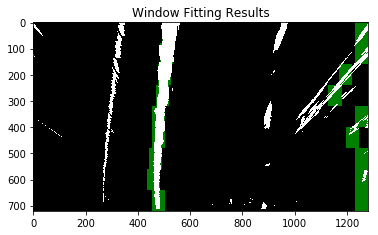

In [6]:
# Code source from Udacity Lesson "Advance Techniques for Lane Finding"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = filtered_bird_eye
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('Window Fitting Results')
plt.savefig('./img/conv_win.jpg')
plt.show()


### 4.2 Sliding Windows Method

476.71357240057523 900.5560631580449


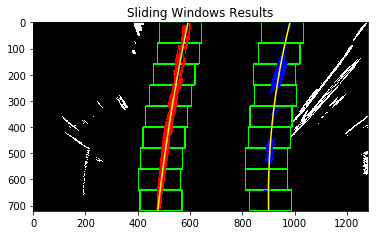

In [7]:
# Code source from Udacity Lesson "Advance Techniques for Lane Finding"
import numpy as np
import cv2
import matplotlib.pyplot as plt

TEST_IMG_PATH = "./test_images/test6.jpg"
filtered_bird_eye, Minv = pipeline(TEST_IMG_PATH)
warped = filtered_bird_eye

# Assuming you have created a warped binary image called "warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
quarter_point = np.int(midpoint//2)
# Previously the left/right base was the max of the left/right half of the histogram
# this changes it so that only a quarter of the histogram (directly to the left/right) is considered
leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 80
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 3) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 


# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Visualization
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

print(left_fitx[-1], right_fitx[-1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title("Sliding Windows Results")
plt.savefig('./img/slide_win.jpg')
plt.show()

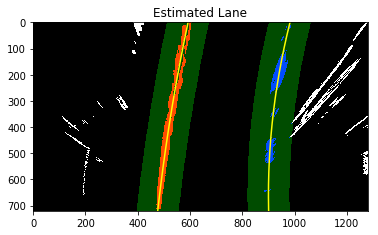

In [8]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title("Estimated Lane")
plt.savefig('./img/lane_drawn.jpg')
plt.show()

# Step 5 Calculate Distance from Center of Lane and Curvature

In [9]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/400 # meters per pixel in x dimension

### 5.1 Calculate Distance from Center of Lane

In [10]:
# Calculate Distance from center of the lane
car_position = warped.shape[1] / 2
h = warped.shape[0]
lane_center = (left_fitx + right_fitx) / 2
lane_offset = (car_position - lane_center[-1]) * xm_per_pix
print("Distance from Center of Lane {:.3f} m".format(lane_offset))

Distance from Center of Lane -0.450 m


### 5.2 Calculating Curvature

In [11]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print("Left Lane Curvature: {:.3f} pixels, Right Lane Curvature: {:.3f} pixels".format(left_curverad, right_curverad))
# Example values: 1926.74 1908.48

Left Lane Curvature: 7286.122 pixels, Right Lane Curvature: 2640.708 pixels


In [12]:
y_eval = np.max(ploty)

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print("Left Lane Curvature: {:.3f} m, Right Lane Curvature: {:.3f} m".format(left_curverad, right_curverad))
# Example values: 632.1 m    626.2 m

Left Lane Curvature: 1344.024 m, Right Lane Curvature: 495.262 m


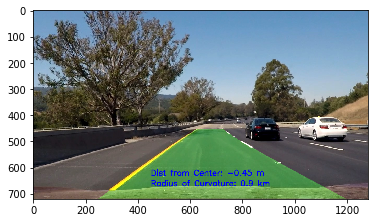

In [13]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

orig_img = mpimg.imread(TEST_IMG_PATH)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (orig_img.shape[1], orig_img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(orig_img, 1, newwarp, 0.3, 0)

font = cv2.FONT_HERSHEY_SIMPLEX
curvature = 0.5*(left_curverad + right_curverad)/1000
reportTxt1 = "Dist from Center: {:.2f} m".format(lane_offset)
reportTxt2 = "Radius of Curvature: {:.1f} km".format(curvature)

cv2.putText(result, reportTxt1, (450,630), font, 1, (0,0,255), 2, cv2.LINE_AA)
cv2.putText(result, reportTxt2, (450,670), font, 1, (0,0,255), 2, cv2.LINE_AA) 

plt.imshow(result)

# Step 6: Test Complete Pipeline

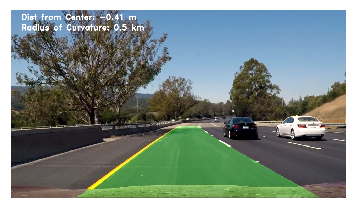

In [14]:
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from advLaneFind import find_lane


COEF_PATH = "./presets/calibrate.p"
dist_pickle = pickle.load(open(COEF_PATH, "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

img = mpimg.imread("./test_images/test6.jpg")

result = find_lane(img, mtx, dist, None)
fig = plt.imshow(result)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.axis('off')
plt.savefig('./img/result3.png', bbox_inches='tight', pad_inches = 0)

In [15]:
import pickle
from moviepy.editor import VideoFileClip
from advLaneFind import find_lane

COEF_PATH = "./presets/calibrate.p"
dist_pickle = pickle.load(open(COEF_PATH, "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def process_img(img):
    return find_lane(img, mtx, dist, None)

In [16]:
video_out = 'project_video_output_rev.mp4'
video_in = VideoFileClip('./project_video.mp4')
processed_video = video_in.fl_image(process_img)
%time processed_video.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video project_video_output_rev.mp4
[MoviePy] Writing video project_video_output_rev.mp4


100%|█████████▉| 1260/1261 [08:40<00:00,  2.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_rev.mp4 

CPU times: user 8min 25s, sys: 1min 30s, total: 9min 56s
Wall time: 8min 42s


In [8]:
video_out = 'challenge_video_output.mp4'
video_in = VideoFileClip('./challenge_video.mp4')
processed_video = video_in.fl_image(process_img)
%time processed_video.write_videofile(video_out, audio=False, progress_bar=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 



In [10]:
video_out = 'harder_challenge_video_output.mp4'
video_in = VideoFileClip('./harder_challenge_video.mp4')
processed_video = video_in.fl_image(process_img)
%time processed_video.write_videofile(video_out, audio=False, progress_bar=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 8min 21s, sys: 1min 25s, total: 9min 46s
Wall time: 8min 17s
